In [1]:
import torch
from torch import nn


## Yolo model

In [2]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1)
]

In [3]:
class CNNBlock(nn.Module):
  def __init__(self,
               in_channels,
               out_channels,
               **kwargs):
    super().__init__()
    self.conv = nn.Conv2d(in_channels=in_channels,
                          out_channels=out_channels,
                          bias=False,
                          **kwargs)
    self.batch_norm = nn.BatchNorm2d(num_features=out_channels)
    self.leaky_relu = nn.LeakyReLU(0.1)

  def forward(self, x):
    return self.leaky_relu(self.batch_norm(self.conv(x)))


In [22]:
class YoloV1(nn.Module):
  def __init__(self,
               in_channels=3,
               **kwargs):
    super().__init__()
    self.architecture = architecture_config
    self.in_channels = in_channels
    self.darknet = self._create_conv_layers(self.architecture)
    self.fcs = self._create_fcs(**kwargs)

  def forward(self, x):
    x = self.darknet(x)
    return self.fcs(torch.flatten(x, start_dim=1))

  def _create_conv_layers(self, architecture):
    layers = []
    in_channels = self.in_channels

    for x in architecture:
      if type(x) == tuple:
        layers += [CNNBlock(in_channels=in_channels,
                           out_channels=x[1],
                           kernel_size=x[0],
                           stride=x[2],
                           padding=x[3])]
        in_channels = x[1]

      elif type(x) == str:
        layers += [nn.MaxPool2d(kernel_size=2,
                               stride=2)]
      elif type(x) == list:
        conv1 = x[0]
        conv2 = x[1]
        num_repeats = x[2]

        for _ in range(num_repeats):
          layers += [CNNBlock(in_channels=in_channels,
                             out_channels=conv1[1],
                             kernel_size=conv1[0],
                             stride=conv1[2],
                             padding=conv1[3])]

          in_channels = conv1[1]
          layers += [CNNBlock(in_channels=in_channels,
                             out_channels=conv2[1],
                             kernel_size=conv2[0],
                             stride=conv2[2],
                             padding=conv2[3])]
          in_channels = conv2[1]

    return nn.Sequential(*layers)

  def _create_fcs(self, split_size, num_boxes, num_classes):
    S, B, C = split_size, num_boxes, num_classes
    return nn.Sequential(
        nn.Flatten(),
        nn.Linear(1024*S*S, 496),
        nn.Dropout(0.0),
        nn.LeakyReLU(0.1),
        nn.Linear(496, S*S*(C+B*5)),
    )

In [5]:
test = torch.randn(size=(2,3, 448, 448))
model = YoloV1(split_size=7, num_boxes=2, num_classes=20)
model(test).shape

torch.Size([2, 1470])

## Loss function

In [6]:
!wget https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/object_detection/YOLO/utils.py

--2024-07-11 09:22:16--  https://raw.githubusercontent.com/aladdinpersson/Machine-Learning-Collection/master/ML/Pytorch/object_detection/YOLO/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11922 (12K) [text/plain]
Saving to: 'utils.py'

utils.py            100%[===================>]  11.64K  --.-KB/s    in 0s      

2024-07-11 09:22:16 (55.9 MB/s) - 'utils.py' saved [11922/11922]



In [7]:
import torch
import torch.nn as nn
from utils import intersection_over_union

In [77]:
class YoloLoss(nn.Module):
  def __init__(self, S=7, B=2, C=20):
    super().__init__()
    self.mse = nn.MSELoss(reduction="sum")
    self.S = S
    self.B = B
    self.C = C
    self.lambda_noobj = 0.5
    self.lambda_coord = 5

  def forward(self, predictions, target):
    predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B*5)

    iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
    iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
    ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
    iou_maxes, best_box = torch.max(ious, dim=0)
    exists_box = target[..., 20].unsqueeze(3)

    ## FOR BOX COORDINATES

    box_predictions = exists_box * (best_box * predictions[..., 26:30] + (1 - best_box) * predictions[..., 21:25])
    box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(torch.abs(box_predictions[..., 2:4] + 1e-6))

    box_targets = exists_box * target[..., 21:25]
    box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

    box_loss = self.mse(torch.flatten(box_predictions, end_dim=-2), torch.flatten(box_targets, end_dim=-2))

    ## FOR OBJECT LOSS
    pred_box = (best_box * predictions[..., 25:26] + (1 - best_box) * predictions[..., 20:21])
    object_loss = self.mse(torch.flatten(exists_box * pred_box), torch.flatten(exists_box * target[..., 20:21]))

    ## FOR NO OBJECT LOSS
    no_object_loss = self.mse(torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
                              torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1))

    no_object_loss = self.mse(torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
                              torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1))

    ## FOR CLASS LOSS
    class_loss = self.mse(torch.flatten(exists_box * predictions[..., :20], end_dim=-2),
                          torch.flatten(exists_box * target[..., :20], end_dim=-2))

    loss = self.lambda_coord * box_loss + object_loss + self.lambda_noobj * no_object_loss + class_loss

    return loss

## Loading the dataset

In [78]:
# %%writefile dataset.py

import torch
import os
import pandas as pd
from PIL import Image

class VOCDataset(torch.utils.data.Dataset):
    def __init__(self,
                 csv_file,
                 img_dir, 
                 label_dir,
                 S=7,
                 B=2,
                 C=20, 
                 transform=None):
        self.annotations = pd.read_csv(csv_file)
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.transform = transform
        self.S = S
        self.B = B
        self.C = C
        
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        label_path = os.path.join(self.label_dir, self.annotations.iloc[index, 1])
        boxes = []
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [float(x) if float(x) != int(float(x)) else int(x) 
                                                    for x in label.replace("\n", "").split()]
                
                boxes.append([class_label, x, y, width, height])
                
        img_path = os.path.join(self.img_dir, self.annotations.iloc[index, 0])
        image = Image.open(img_path)
        boxes = torch.tensor(boxes)
        
        if self.transform:
            image, boxes = self.transform(image, boxes)
        
        label_matrix = torch.zeros((self.S, self.S, self.C+5*self.B))
        for box in boxes:
            class_label, x, y, width, height = box.tolist()
            class_label = int(class_label)
            i, j = int(self.S*y), int(self.S*x)
            X_cell, y_cell = self.S * x - j, self.S * y - i
            width_cell, height_cell = (width * self.S, height * self.S)
            
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1
                box_coordinates = torch.tensor([X_cell, y_cell, width_cell, height_cell])
                label_matrix[i, j, 21:25] = box_coordinates
                label_matrix[i, j, class_label] = 1
                
        return image, label_matrix

## training

In [79]:
import torch
from torchvision import transforms
from torch import optim
import torchvision.transforms.functional as FT
from tqdm import tqdm
from torch.utils.data import DataLoader
from utils import intersection_over_union, non_max_suppression, mean_average_precision
from utils import cellboxes_to_boxes, get_bboxes, plot_image, save_checkpoint, load_checkpoint

In [80]:
torch.manual_seed(42)
LEARNING_RATE= 2e-5
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE = 16
WEIGHT_DECAY = 0
EPOCHS = 100
NUM_WORKERS = 2
PIN_MEMORY = True
LOAD_MODEL = False
LOAD_MODEL_FILE = "overfit.pth"
IMG_DIR = "/kaggle/input/pascalvoc-yolo/images"
LABEL_DIR = "/kaggle/input/pascalvoc-yolo/labels"


In [81]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms
    
    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes
        
        return img, bboxes

In [82]:
transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor()])

In [89]:
def train_fn(train_loader, model, optimizer, loss_fn):
    loop = tqdm(train_loader, leave=True)
    mean_loss = []
    for batch_idx, (X, y) in enumerate(loop):
        X, y = X.to(DEVICE), y.to(DEVICE)
        out = model(X)
        loss = loss_fn(out, y)
        mean_loss.append(loss.item())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        loop.set_postfix(loss = loss.item())
    print(f"loss: {sum(mean_loss)/len(mean_loss)}")
    


In [90]:
model = YoloV1(split_size=7, num_boxes=2, num_classes=20).to(DEVICE)
optimizer = optim.Adam(model.parameters(),
                      lr=LEARNING_RATE, 
                      weight_decay=WEIGHT_DECAY)
loss_fn = YoloLoss()

if LOAD_MODEL:
    load_checkpoint(torch.load(LOAD_MODEL_FILE), model, optimizer)
    
train_dataset = VOCDataset("/kaggle/input/pascalvoc-yolo/8examples.csv",
                          transform=transform,
                          img_dir=IMG_DIR,
                          label_dir=LABEL_DIR)

test_dataset = VOCDataset("/kaggle/input/pascalvoc-yolo/test.csv",
                         transform=transform,
                         img_dir=IMG_DIR,
                         label_dir=LABEL_DIR)

train_loader = DataLoader(dataset=train_dataset,
                         batch_size=BATCH_SIZE,
                         num_workers=NUM_WORKERS,
                         pin_memory=PIN_MEMORY,
                         shuffle=True,
                         drop_last=False)

test_loader = DataLoader(dataset=test_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        drop_last=False)

In [93]:
for epoch in range(EPOCHS):
#     for x, y in train_loader:
#         x = x.to(DEVICE)
#         for idx in range(8):
#             bboxes = cellboxes_to_boxes(model(x))
#             bboxes = non_max_suppression(bboxes[idx], 
#                                          iou_threshold=0.5,
#                                         threshold=0.4,
#                                         box_format="midpoint")
#             plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)
            
#         import sys
#         sys.exit()
    pred_boxes, target_boxes = get_bboxes(train_loader, 
                                         model, 
                                         iou_threshold=0.5, 
                                         threshold=0.4)
    
    mean_avg_prec = mean_average_precision(pred_boxes, 
                                          target_boxes, 
                                          iou_threshold=0.5,
                                          box_format="midpoint")
    
    print(f"Train mAP: {mean_avg_prec}")
    train_fn(train_loader, 
             model, 
             optimizer, 
             loss_fn)

Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.00047]

loss: 0.0004701979923993349


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  2.97it/s, loss=0.000431]

loss: 0.0004310245858505368


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  2.95it/s, loss=0.000398]

loss: 0.0003982117341365665


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.000364]

loss: 0.0003642764640972018


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  2.08it/s, loss=0.000326]

loss: 0.0003257938369642943


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.000287]

loss: 0.00028695788932964206


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  2.79it/s, loss=0.000257]

loss: 0.0002570343785919249


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  2.93it/s, loss=0.000233]

loss: 0.00023330203839577734


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.000209]

loss: 0.0002089640765916556


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.000182]

loss: 0.00018150877440348268


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.000152]

loss: 0.0001519432698842138


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.14it/s, loss=0.000133]

loss: 0.00013300955470185727


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.06it/s, loss=0.000117]

loss: 0.0001172048068838194


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.18it/s, loss=0.000104]

loss: 0.00010354585538152605


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.15it/s, loss=9.37e-5]

loss: 9.371685155201703e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.15it/s, loss=8.77e-5]

loss: 8.77057173056528e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.14it/s, loss=8.27e-5]

loss: 8.273414277937263e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.15it/s, loss=7.82e-5]

loss: 7.816363358870149e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=7.28e-5]

loss: 7.281944272108376e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=6.69e-5]

loss: 6.688080611638725e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.01it/s, loss=6.12e-5]

loss: 6.122155173216015e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.08it/s, loss=5.74e-5]

loss: 5.744260488427244e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.09it/s, loss=5.49e-5]

loss: 5.487415910465643e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=5.85e-5]

loss: 5.8539615565678105e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=7.84e-5]

loss: 7.839617319405079e-05


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.000144]

loss: 0.00014422043750528246


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  2.99it/s, loss=0.000344]

loss: 0.00034381146542727947


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.000942]

loss: 0.0009418116533197463


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.00277]

loss: 0.002769722603261471


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.09it/s, loss=0.00846]

loss: 0.008455646224319935


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.14it/s, loss=0.0263]

loss: 0.02628321200609207


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.0819]

loss: 0.08193089812994003


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.18it/s, loss=0.243]

loss: 0.24257615208625793


Train mAP: 0.3681427538394928


100%|██████████| 1/1 [00:00<00:00,  3.08it/s, loss=0.632]

loss: 0.6319355368614197


Train mAP: 0.36210712790489197


100%|██████████| 1/1 [00:00<00:00,  3.18it/s, loss=1.27]

loss: 1.272667407989502


Train mAP: 0.3681427538394928


100%|██████████| 1/1 [00:00<00:00,  3.15it/s, loss=1.62]

loss: 1.6158828735351562


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.05it/s, loss=0.885]

loss: 0.884793221950531


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.00it/s, loss=0.0312]

loss: 0.031242672353982925


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  2.98it/s, loss=0.431]

loss: 0.4314199388027191


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.00it/s, loss=0.862]

loss: 0.861804187297821


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.266]

loss: 0.266215980052948


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.06it/s, loss=0.0849]

loss: 0.0849476307630539


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.539]

loss: 0.5394877791404724


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.04it/s, loss=0.282]

loss: 0.28230348229408264


Train mAP: 0.36905157566070557


100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.0545]

loss: 0.05454498529434204


Train mAP: 0.37414243817329407


100%|██████████| 1/1 [00:00<00:00,  3.20it/s, loss=0.381]

loss: 0.3810098171234131


Train mAP: 0.3736811876296997


100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.236]

loss: 0.23574231564998627


Train mAP: 0.3829404413700104


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.0836]

loss: 0.08364446461200714


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.09it/s, loss=0.307]

loss: 0.3072277307510376


Train mAP: 0.3829404413700104


100%|██████████| 1/1 [00:00<00:00,  3.14it/s, loss=0.16]

loss: 0.15993790328502655


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0782]

loss: 0.07823170721530914


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.205]

loss: 0.20455676317214966


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  2.99it/s, loss=0.055]

loss: 0.05501682683825493


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.0593]

loss: 0.0592547282576561


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.02it/s, loss=0.133]

loss: 0.13287630677223206


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.14it/s, loss=0.0301]

loss: 0.030090823769569397


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  2.94it/s, loss=0.0885]

loss: 0.08854584395885468


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  2.95it/s, loss=0.102]

loss: 0.1020754873752594


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.0325]

loss: 0.03253606706857681


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.0831]

loss: 0.08306077867746353


Train mAP: 0.38803133368492126


100%|██████████| 1/1 [00:00<00:00,  3.18it/s, loss=0.0466]

loss: 0.046578776091337204


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0148]

loss: 0.014801159501075745


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0533]

loss: 0.05329281836748123


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.01it/s, loss=0.0143]

loss: 0.014303994365036488


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.15it/s, loss=0.0234]

loss: 0.023359958082437515


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.0453]

loss: 0.04526377469301224


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.0148]

loss: 0.014840305782854557


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.0348]

loss: 0.03479251265525818


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.04it/s, loss=0.0324]

loss: 0.03237377107143402


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.0105]

loss: 0.010489337146282196


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0274]

loss: 0.02737055905163288


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.07it/s, loss=0.0134]

loss: 0.013440503738820553


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.15it/s, loss=0.00524]

loss: 0.005237416364252567


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.0189]

loss: 0.018868619576096535


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0062]

loss: 0.006201563868671656


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0101]

loss: 0.010064195841550827


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.02it/s, loss=0.0214]

loss: 0.021356875076889992


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.0161]

loss: 0.016125256195664406


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.07it/s, loss=0.0315]

loss: 0.03153916820883751


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.18it/s, loss=0.0512]

loss: 0.05117717385292053


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.072]

loss: 0.07196827232837677


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.125]

loss: 0.12511955201625824


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.199]

loss: 0.19881248474121094


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.291]

loss: 0.29147782921791077


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  2.94it/s, loss=0.395]

loss: 0.3951159119606018


Train mAP: 0.3968276083469391


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.438]

loss: 0.4382338225841522


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.12it/s, loss=0.372]

loss: 0.37249791622161865


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.216]

loss: 0.21626164019107819


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.0589]

loss: 0.058949362486600876


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.16it/s, loss=0.0119]

loss: 0.011891507543623447


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.09it/s, loss=0.0795]

loss: 0.07951517403125763


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.161]

loss: 0.16097091138362885


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.06it/s, loss=0.174]

loss: 0.17430266737937927


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.13it/s, loss=0.112]

loss: 0.11163689196109772


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.03it/s, loss=0.0364]

loss: 0.03641052916646004


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.07it/s, loss=0.0211]

loss: 0.02110464498400688


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.17it/s, loss=0.0568]

loss: 0.05682487040758133


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.0837]

loss: 0.08369741588830948


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.10it/s, loss=0.0756]

loss: 0.07556129992008209


Train mAP: 0.3917367458343506


100%|██████████| 1/1 [00:00<00:00,  3.11it/s, loss=0.0511]

loss: 0.05108937993645668


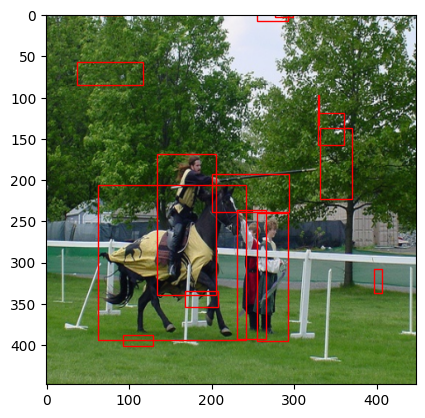

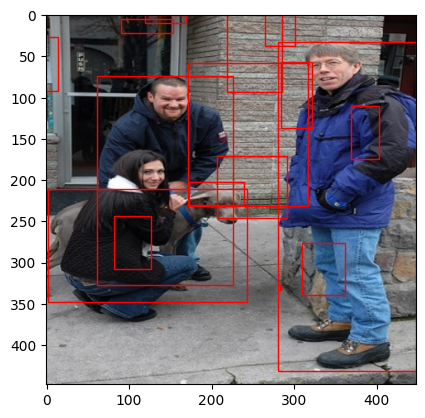

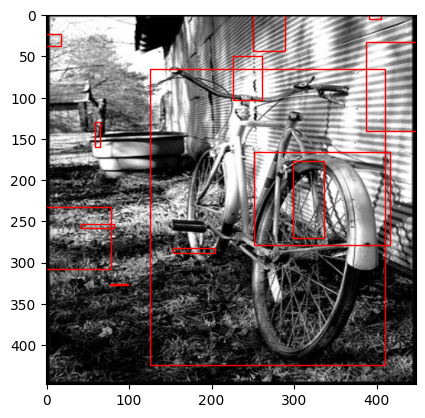

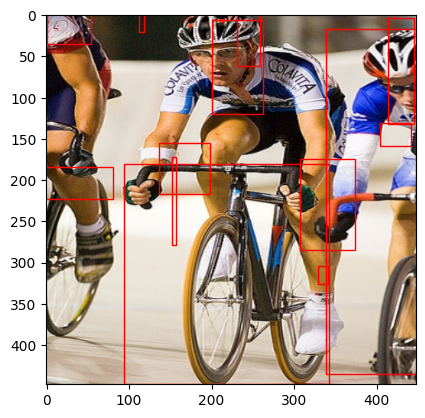

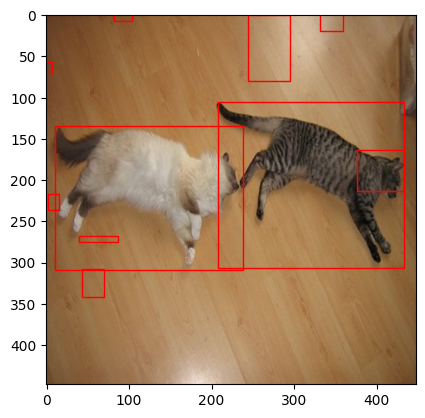

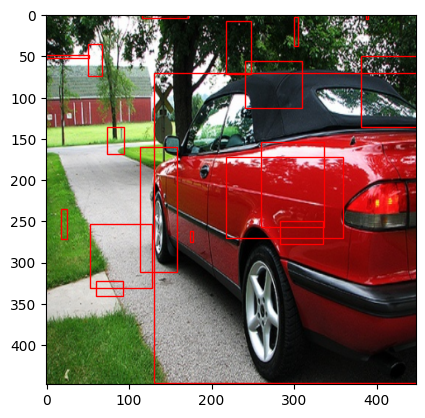

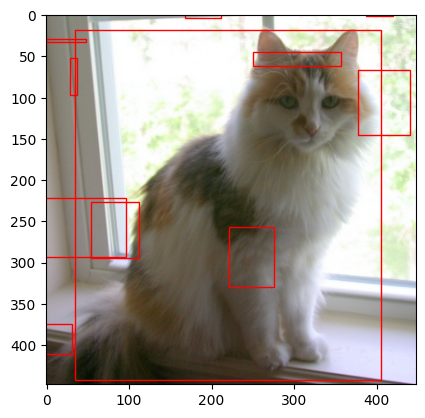

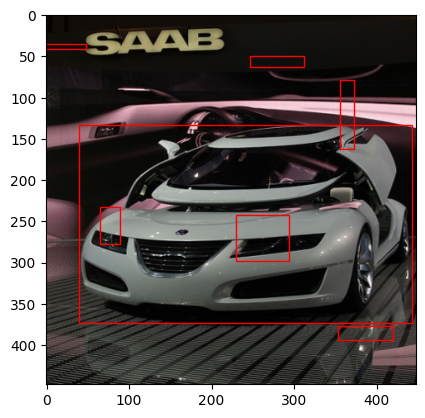

In [94]:
for x, y in train_loader:
    x = x.to(DEVICE)
    for idx in range(8):
        bboxes = cellboxes_to_boxes(model(x))
        bboxes = non_max_suppression(bboxes[idx], 
                                     iou_threshold=0.5,
                                    threshold=0.4,
                                    box_format="midpoint")
        plot_image(x[idx].permute(1,2,0).to("cpu"), bboxes)

